In [1]:
import deepSI
import numpy as np

class DuffingOscillator(deepSI.System_deriv):
    def __init__(self):
        super(DuffingOscillator, self).__init__(nx=2, dt=0.1)
        self.alpha = 1
        self.beta = 5
        self.gamma = 1
        self.delta = 1.5
        self.omega = 0.5

    def deriv(self,x,u):
        z1,z2 = x
        dz1 = self.gamma*u - self.delta*z1 - self.alpha*z2 - self.beta*(z2**3)
        dz2 = z1
        return [dz1,dz2]

    def h(self,x,u):
        #return x[1]
        return x

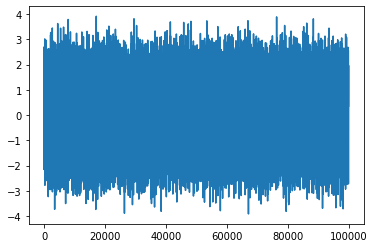

In [2]:
from matplotlib import pyplot as plt
u = deepSI.deepSI.exp_design.multisine(100000, pmax=40001, n_crest_factor_optim=20)
#u = deepSI.deepSI.exp_design.multisine(1000, pmax=401)
plt.plot(u)

In [3]:
sys_Duff = DuffingOscillator()

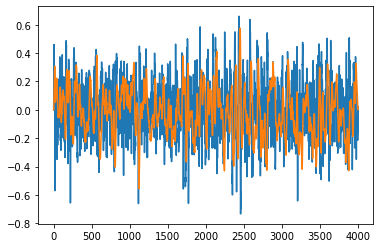

In [4]:
data = sys_Duff.apply_experiment(deepSI.System_data(u=u))
plt.plot(data.y[0:4000])

In [5]:
from torch import nn
import torch
class stateSelector(nn.Module):
    def __init__(self): 
        super(stateSelector,self).__init__()

    def forward(self,x):
        return torch.mm(x, torch.tensor([[0.0],[1.0]], dtype=torch.float))

In [6]:
from torch import nn
class I_encoder(deepSI.fit_systems.SS_encoder):
    def __init__(self, nx = 2, na=2, nb=2, feedthrough=False) -> None:
        super().__init__(nx=nx, na=na, nb=nb, feedthrough=feedthrough)

    def init_nets(self, nu, ny): # a bit weird
        ny = ny if ny is not None else 1
        nu = nu if nu is not None else 1
        self.encoder = self.e_net(self.nb*nu+self.na*ny, self.nx, n_nodes_per_layer=self.e_n_nodes_per_layer, n_hidden_layers=self.e_n_hidden_layers, activation=self.e_activation)
        self.fn =      self.f_net(self.nx+nu,            self.nx, n_nodes_per_layer=self.f_n_nodes_per_layer, n_hidden_layers=self.f_n_hidden_layers, activation=self.f_activation)
        hn_in = self.nx + nu if self.feedthrough else self.nx
        #self.hn =      stateSelector()
        self.hn =      nn.Identity(hn_in)#self.h_net(hn_in     ,            ny,      n_nodes_per_layer=self.h_n_nodes_per_layer, n_hidden_layers=self.h_n_hidden_layers, activation=self.h_activation)

In [7]:
I_enc = I_encoder(nx=2, na=2, nb=2, feedthrough=False)
train, test = data.train_test_split(split_fraction=0.2)
train, val  = train.train_test_split(split_fraction=0.25)

I_enc.fit(train_sys_data=train, val_sys_data=val, epochs=50, batch_size=256, loss_kwargs={'nf':150})

Initilizing the model and optimizer
Size of the training array =  208.2 MB
N_training_samples = 59849, batch_size = 256, N_batch_updates_per_epoch = 233
Initial Validation sim-NRMS= 1.0701283900139686


  0%|          | 0/50 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.3486704472802027
Epoch    1, sqrt loss  0.5723, Val sim-NRMS 0.3487, Time Loss: 91.1%, data: 0.3%, val: 8.6%,  7.3 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.2667618531577617
Epoch    2, sqrt loss  0.3127, Val sim-NRMS 0.2668, Time Loss: 91.3%, data: 0.3%, val: 8.4%,  7.2 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.1348381603461441
Epoch    3, sqrt loss  0.2078, Val sim-NRMS 0.1348, Time Loss: 91.2%, data: 0.3%, val: 8.5%,  7.2 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.09468671616162039
Epoch    4, sqrt loss  0.1125, Val sim-NRMS 0.09469, Time Loss: 91.2%, data: 0.3%, val: 8.5%,  7.2 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.08374051365877763
Epoch    5, sqrt loss 0.09096, Val sim-NRMS 0.08374, Time Loss: 91.0%, data: 0.3%, val: 8.7%,  7.2 batches/sec
#

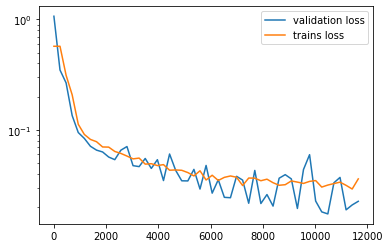

In [8]:
I_enc.checkpoint_load_system('_last')
plt.semilogy(I_enc.batch_id,I_enc.Loss_val,label='validation loss')
plt.semilogy(I_enc.batch_id,I_enc.Loss_train**0.5,label='trains loss')
plt.legend()

In [9]:
test_ss_enc = I_enc.apply_experiment(test,save_state=True)
X = test_ss_enc.x

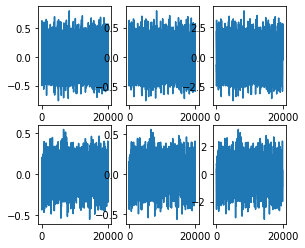

In [10]:
plt.subplot(2,4,1)
plt.plot(test.y[:,0])
plt.subplot(2,4,2)
plt.plot(test_ss_enc.y[:,0])
plt.subplot(2,4,3)
plt.plot(X[:,0])

plt.subplot(2,4,5)
plt.plot(test.y[:,1])
plt.subplot(2,4,6)
plt.plot(test_ss_enc.y[:,1])
plt.subplot(2,4,7)
plt.plot(X[:,1])

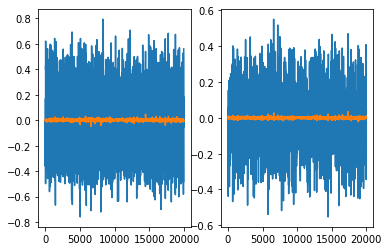

In [11]:
plt.subplot(1,2,1)
plt.plot(test.y[:,0])
plt.plot(test.y[:,0] - test_ss_enc.y[:,0])
plt.subplot(1,2,2)
plt.plot(test.y[:,1])
plt.plot(test.y[:,1] - test_ss_enc.y[:,1])

In [13]:
I_enc.save_system("systems/FullOutputSS_dt01_e50")

In [ ]:
import deepSI
# first declare I_encoder above
#I_enc = deepSI.load_system("systems/FullOutputSS_dt01_e50")

In [23]:
# function that converts torch nn to casadi expression

from casadi import *

def CasADiFn(ss_enc, x, u):
    n_hidden_layers = ss_enc.f_n_hidden_layers
    nu = ss_enc.nu if ss_enc.nu is not None else 1

    params = {}
    for name, param in ss_enc.fn.named_parameters():
        params[name] = param.detach().numpy()
    params_list = list(params.values())
    
    xu = vertcat(x,u)

    temp_nn = xu
    for i in range(n_hidden_layers):
        W_NL = params_list[2+i*2]
        b_NL = params_list[3+i*2]
        temp_nn = mtimes(W_NL, temp_nn)+b_NL
        temp_nn = tanh(temp_nn)
    W_NL = params_list[2+n_hidden_layers*2]
    b_NL = params_list[3+n_hidden_layers*2]
    nn_NL = mtimes(W_NL, temp_nn)+b_NL

    W_Lin = params_list[0]
    b_Lin = params_list[1]
    nn_Lin = mtimes(W_Lin,xu) + b_Lin

    #f = Function('f', [x, u], [nn_NL + nn_Lin])
    return nn_NL + nn_Lin

In [24]:
# function that checks whether torch nn and casadi function have the same behavior

import torch

def checkCasADiFn(ss_enc, casadi_fn):
    nu = 1000
    u = (torch.rand(nu,3)*2-1)*2
    ss_out = ss_enc.fn(u).detach().numpy()

    check = True
    for i in range(nu):
        xin = u[i,0:2].numpy().tolist()
        uin = u[i,2].item()
        cas_out = f(xin, uin).elements()
        #equality_array = np.unique(np.round(np.array(cas_out) - ss_out[i,:], decimals=5) == 0.00000) #use np.isclose and np.all
        if np.allclose(np.array(cas_out), ss_out[i,:], rtol=1e-05, atol=1e-05) == False:
        #if equality_array.size != 1 or equality_array[0] == False:
            check = False

    return check

In [25]:
# declared sym variables
x = MX.sym("x",I_enc.nx,1)
nu = I_enc.nu if I_enc.nu is not None else 1
u = MX.sym("u",nu,1)

# convert torch nn to casadi function
rhs = CasADiFn(I_enc, x, u)
f = Function('f', [x, u], [rhs])

# check if torch nn and casadi function have same behavior
check = checkCasADiFn(I_enc, f)
check

True

In [26]:
# apply correction to casadi function such that fc(0) = 0
correction = f([0,0], 0)
rhs_c = rhs - correction
f_c = Function('f_c', [x, u], [rhs_c])
f_c([0,0], 0)

DM([0, 0])

In [27]:
# Box constraints
x_min = -100
x_max = 100
u_min = -100
u_max = 100

# Initial and final values
x0 = [0,0]
x_ref = np.array([[0],[40]])
u_ref = 0

# Weight matrices for the cost function
#Q = 100
Q = np.matrix('0,0;0,100')
R = 0.001

# MPC parameters
dt = 1/10
Nc = 5
Nsim = 80
dlam = 0.01
stages = 1

In [28]:
from my_rk4 import *
from lpv_int import *
from lpv_rk4 import *
import numpy as np
import time

opti = Opti()

# declare variables and parameters of states and inputs
n_states = np.shape(x)[0]
states = opti.variable(n_states,Nc+1)    
x_initial = opti.parameter(n_states,1)

n_controls = np.shape(u)[0]
controls = opti.variable(n_controls,Nc)

# determine getA and getB functions
Jfx = Function("Jfx", [x, u], [jacobian(rhs_c,x)])
Jfu = Function("Jfu", [x, u], [jacobian(rhs_c,u)])
[A_sym, B_sym] = lpv_int(x,n_states,u,n_controls,Jfx,Jfu,dlam,stages)
get_A = Function("get_A",[x,u],[A_sym])
get_B = Function("get_B",[x,u],[B_sym])

list_A = opti.parameter(Nc*n_states,n_states)
list_B = opti.parameter(Nc*n_states,n_controls)

# declare bounds of system
opti.subject_to(opti.bounded(x_min,states,x_max))
opti.subject_to(opti.bounded(u_min,controls,u_max))
opti.subject_to(states[:,0] == x_initial)

opts = {'print_time' : 0, 'ipopt': {'print_level': 0}}
opti.solver("ipopt",opts)

In [82]:
x1 = np.array([0,0])
X1 = x1
u1 = deepSI.deepSI.exp_design.multisine(100000, pmax=40001, n_crest_factor_optim=20)

for ui in u1[:2000]:
    u_norm = I_enc.norm.transform(deepSI.System_data(u=ui)).u
    A = get_A(x1,u_norm)
    B = get_B(x1,u_norm)
    x1 = A@x1 + B*ui
    X1 = np.vstack((X1, x1.full().T))
    

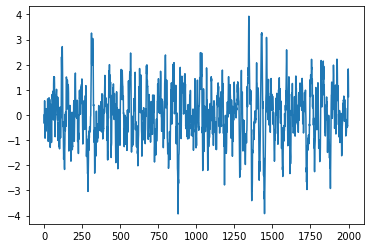

In [83]:
plt.plot(X1[:,0])

In [ ]:
objective = 0 #maybe add some soft bounds on the states and inputs
for i in np.arange(Nc):
    opti.subject_to(states[:,i+1] == lpv_rk4(states[:,i],controls[:,i],\
        list_A[(n_states*i):(n_states*i+n_states),:],list_B[(n_states*i):(n_states*i+n_states),:],dt, correction)) # should this be changed to discrete time model
    objective = (objective + 
                    mtimes(mtimes((states[:,i]-x_ref).T,Q),(states[:,i]-x_ref)) +
                    mtimes(mtimes((controls[:,i]-u_ref).T,R),(controls[:,i]-u_ref)))

opti.minimize(objective)

In [ ]:
# logging list
u_log = np.zeros([n_controls,Nsim])
t = np.zeros(Nsim)
t0 = 0
x_log = np.zeros([n_states,Nsim+1])
start = time.time()

# iteration values
lpv_counter = np.zeros(Nsim,int)

# set initial values for x
x = np.zeros([n_states,Nc+1]) # np.repeat(x0, NC+1)change this to x0 instead of 0
u = np.zeros([n_controls,Nc]) # change this to u0 instead of 0 maybe
opti.set_initial(states, x)
opti.set_initial(controls, u)
opti.set_value(x_initial,x0)
#x[:,0] = np.ravel(x0)

for mpciter in np.arange(Nsim):
    # determine A,B
    for i in np.arange(Nc):
        opti.set_value(list_A[(n_states*i):(n_states*i+n_states),:],get_A(x[:,i],u[:,i]))
        opti.set_value(list_B[(n_states*i):(n_states*i+n_states),:],get_B(x[:,i],u[:,i]))
    
    # solve for u and x
    sol = opti.solve();
    u_old = u
    u = np.reshape(sol.value(controls),[n_controls,Nc])
    for i in np.arange(Nc):
        x[:,i+1] = np.ravel(my_rk4(x[:,i],u[:,i],f,dt),order='F') # change this to f_c of f?
    #x = np.reshape(sol.value(states),[n_states,Nc+1])
    opti.set_initial(states, x)
    opti.set_initial(controls, u)

    lpv_counter[mpciter] += 1

    while (lpv_counter[mpciter] < 10) and (np.linalg.norm(u-u_old) > 1e-5):
        # determine A,B
        for i in np.arange(Nc):
            opti.set_value(list_A[(n_states*i):(n_states*i+n_states),:],get_A(x[:,i],u[:,i]))
            opti.set_value(list_B[(n_states*i):(n_states*i+n_states),:],get_B(x[:,i],u[:,i]))
        
        # solve for u and x
        sol = opti.solve()
        u_old = u
        u = np.reshape(sol.value(controls),[n_controls,Nc])

        # simulate next step using rk4 over non correction casadi function
        for i in np.arange(Nc):
            x[:,i+1] = np.ravel(my_rk4(x[:,i],u[:,i],f,dt),order='F')
        #x = np.reshape(sol.value(states),[n_states,Nc+1]) # change this to nn maybe
        
        # set new x and u values into optimizer
        opti.set_initial(states, x)
        opti.set_initial(controls, u)

        lpv_counter[mpciter] += 1  

    print("MPC iteration: ", mpciter+1)
    print("LPV counter: ", lpv_counter[mpciter])

    t[mpciter] = t0
    t0 = t0 + dt
    try:
        x = x.full()
    except:
        x = x
    try:
        u = u.full()
    except:
        u = u
    x_log[:,mpciter] = x[:,0]
    u_log[:,mpciter] = u[:,0]
    
    # denormalize x and u and run system step
    #x_denormalized = norm.inverse_transform(deepSI.System_data(y=x0)) # make sure
    x_denormalized = norm.ystd*x0 + norm.y0
    #u_denormalized = norm.inverse_transform(deepSI.System_data(u=u[0,0]))
    u_denormalized = norm.ustd*u[0,0] + norm.u0
    #x0 = x[:,1] # change this to real system step

    # normalize output of system step
    x_denormalized = sys_Duff.f(x_denormalized, u_denormalized)
    x0 = norm.transform(deepSI.System_data(y=x_denormalized))
    x0 = (x_denormalized - norm.y0)/norm.ystd

    x_log[:,mpciter+1] = x0
    
    #!!! add x shift and u shift for hot start
    x = horzcat(x[:,1:(Nc+1)],x[:,-1])
    x[:,0] = x0
    u = horzcat(u[:,1:Nc],u[:,-1])
    opti.set_value(x_initial, x0)
    opti.set_initial(states, x)
    opti.set_initial(controls, u)

end = time.time()
runtime = end - start

In [ ]:
plt.subplot(1,3,1)
plt.plot(x_log[0,:])
plt.subplot(1,3,2)
plt.plot(x_log[1,:])
plt.subplot(1,3,3)
plt.plot(u_log[0,:])

In [ ]:
# u_log = np.zeros([n_controls,Nsim])
# t = np.zeros(Nsim);
# x_log = np.zeros([n_states,Nsim+1])

# u_grid_old = np.zeros([n_controls,Nc])
# u_grid_current = np.zeros([n_controls,Nc])

# for i in np.arange(Nc):
#     opti.set_value(grid_A[(n_states*i):(n_states*i+n_states),:],get_A(x_grid[:,i],u_grid[:,i]))
#     opti.set_value(grid_B[(n_states*i):(n_states*i+n_states),:],get_B(x_grid[:,i],u_grid[:,i]))

# opti.set_value(x_initial,x0);

# start = time.time()

# for mpciter in np.arange(Nsim):
#     x_grid[:,0] = np.ravel(x0)
#     sol = opti.solve()

#     while (lpv_counter[mpciter] < 5) and (np.linalg.norm(u_grid_current-u_grid_old) > 1e-5):
#         # Extract results, use first set of inputs
#         u_grid = np.reshape(sol.value(controls),[n_controls,Nc])
#         x_grid_current = np.reshape(sol.value(states),[n_states,Nc+1])
        
#         # Simulate actual state trajectory
#         for i in np.arange(Nc):
#             # RK4
#             x_grid[:,i+1] = np.ravel(my_rk4(x_grid[:,i],u_grid[:,i],f,dt),order='F') #change this to the actual simulation not integration over nn function
        
#         # Define new A,B,C,D for the grid
#         for i in np.arange(Nc):
#             opti.set_value(grid_A[(n_states*i):(n_states*i+n_states),:],get_A(x_grid[:,i],u_grid[:,i]))
#             opti.set_value(grid_B[(n_states*i):(n_states*i+n_states),:],get_B(x_grid[:,i],u_grid[:,i]))
    
#         lpv_counter[mpciter] = lpv_counter[mpciter] + 1
#         u_grid_old = u_grid_current
#         u_grid_current = u_grid
        
#         opti.set_initial(states, x_grid)
#         opti.set_initial(controls, u_grid)
#         sol = opti.solve()
    
#     print("LPV counter: ", lpv_counter[mpciter])
    
#     t[mpciter] = t0
#     x_log[:,mpciter] = x_grid[:,0]
#     u_log[:,mpciter] = u_grid[:,0]
    
#     t0 = t0 + dt
#     x0 = x_grid[:,1]
#     x_log[:,mpciter+1] = x0
    
#     opti.set_value(x_initial, x0)
#     opti.set_initial(states, horzcat(x_grid_current[:,1:(Nc+1)],x_grid_current[:,-1]))
#     opti.set_initial(controls, horzcat(u_grid[:,1:Nc],u_grid[:,-1]))
    
#     print("MPC iteration: ", mpciter+1)

# end = time.time()
# runtime = end - start